<a href="https://colab.research.google.com/github/RittikeGhosh/Images-Generation-using-DCGAN/blob/main/GenerateSyntheticImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import IPython
print(f"Tensorflow Version: {tf.__version__}")

Tensorflow Version: 2.3.0


### Define a function to display the images passed in grid format

In [2]:
def show_images(images, cols=5):
    '''Displays the images passed as numpy array in grid layout.
    images: 
        accepts array of numpy arrays containing Images 
    cols: 
        number of coloumns in the output'''
    cols = min(cols, len(images))
    rows = (len(images) - 1) // cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(2 * cols, 2 * rows), facecolor='#eeeeee')
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.axis(False)
    plt.show()

### Load Dataset
Load the [*fashion_mnist*](https://keras.io/api/datasets/fashion_mnist/) dataset from the keras library. 
- There are 60, 000 training data of size 28 X 28
- There are 10, 000 testing data of size 28 X 28


Then Normalize the Dataset.

In [3]:
# Load the Dataset 
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print(f"Shape of train data : {x_train.shape}")
print(f"Shape of test data: {x_test.shape}")

4423680/4422102 [==============================] - 0s 0us/step
Shape of train data : (60000, 28, 28)
Shape of test data: (10000, 28, 28)


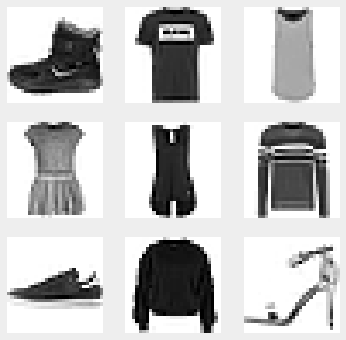

In [4]:
# Normalize the Dataset to [-1, 1]
x_train = x_train.astype(np.float64) / 255
# x_train = (x_train.astype(np.float64) - 127.5) / 127.5
x_test  = x_test.astype(np.float64) / 255
show_images(x_train[:9], cols=3) # Display First 9 images

### Create Mini-Batches
Segregating the Dataset into small batches. The advantages are: 
- More accurate estimation of gradient 
- Faster training 
- Computationaly Less Expensive

In [5]:
batch_size = 32  # set batch size
# Create new dataset from the training set and shuffle the items in it.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(x_train.shape[0])
# Create Batches of Given size
dataset = dataset.batch(batch_size, drop_remainder=True)
print(f"Number of Batches of size {batch_size} created are: {len(list(dataset.as_numpy_iterator()))}")

Number of Batches of size 32 created are: 1875


### Create a Generator Model
It generates an imitation of the data from the noise to trick the discriminator

In [9]:
num_feature = 100
generator = tf.keras.Sequential([
    # A Dense layer to take the noise as input
    keras.layers.Dense(7 * 7 * 256, input_shape=(num_feature,)),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),

    # Reshape the input Layer to the next convulation layer
    keras.layers.Reshape((7, 7, 256)),

    # Transpose Convulation Networks to Upscale the input
    keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),

    keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),

    keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
], name='generator')
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0 

### Test generator model with a random Gaussian Distribution

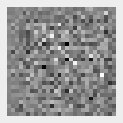

In [10]:
noise = tf.random.normal(shape=(1, num_feature))
generated_image = generator(noise, training=False)
show_images(generated_image, 1)

### Create a Discriminator model
It will test the image generated by the generator and compare it with the train dataset, to check if it is real and how close it is to being real.

In [11]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
], name='discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)            

### Test the decision made by the discriminator on the previously generated images

In [12]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5003323]], shape=(1, 1), dtype=float32)


### Configure the model for training

In [13]:
# generator.compile(loss='binary_crossentropy', optimizer="rmsprop")
# discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
# discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [25]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:

            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            
            # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [26]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()